In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import numpy as np
import matplotlib as plt


%matplotlib inline

In [2]:
from sqlalchemy import create_engine, inspect

In [3]:
# Method 2 - Using Pandas and sqlalchemy
pg_port = '5432'
pg_username = 'pg_username_here'
pg_pw = 'password_here'
pg_db3 = 'EmployeeDB2'
postgresDSN = ('postgresql://{}:{}@{}:{}/{}'.format(pg_username, pg_pw, 'localhost', pg_port, pg_db3))
engine = create_engine(postgresDSN)
cnx = engine.connect()

In [5]:
data_path = 'EmployeeSQL/Data/'

In [6]:
# Salaries Table

query = f'''
Drop Table IF EXISTS Title CASCADE;  
Drop Table IF EXISTS Salary CASCADE;  
Drop Table IF EXISTS Employee CASCADE;  
Drop Table IF EXISTS Dept_Manager CASCADE;  
Drop Table IF EXISTS Dept_Employee CASCADE;  
Drop Table IF EXISTS Department CASCADE;

CREATE TABLE Title (
    title_id VARCHAR(20)   NOT NULL,
    title VARCHAR(50)   NOT NULL,
    CONSTRAINT pk_Title PRIMARY KEY (
        title_id
     )
);

CREATE TABLE Salary (
    emp_no INT   NOT NULL,
    salary Money   NOT NULL,
    CONSTRAINT pk_Salary PRIMARY KEY (
        emp_no
     )
);

CREATE TABLE Employee (
    emp_no INT   NOT NULL,
    emp_title_id VARCHAR(20)   NOT NULL,
    birth_date DATE   NOT NULL,
    first_name VARCHAR(255)   NOT NULL,
    last_name VARCHAR(255)   NOT NULL,
    sex char   NOT NULL,
    hire_date DATE   NOT NULL,
    CONSTRAINT pk_Employee PRIMARY KEY (
        emp_no
     )
);

CREATE TABLE Dept_Manager (
    dept_mgr_id SERIAL   NOT NULL,
    dept_no VARCHAR(20)   NOT NULL,
    emp_no INT   NOT NULL,
    CONSTRAINT pk_Dept_Manager PRIMARY KEY (
        dept_mgr_id
     )
);

CREATE TABLE Dept_Employee (
    dept_emp_id SERIAL   NOT NULL,
    emp_no INT   NOT NULL,
    dept_no VARCHAR(20)   NOT NULL,
    CONSTRAINT pk_Dept_Employee PRIMARY KEY (
        dept_emp_id
     )
);

CREATE TABLE Department (
    dept_no VARCHAR(20)   NOT NULL,
    dept_name VARCHAR(50)   NOT NULL,
    CONSTRAINT pk_Department PRIMARY KEY (
        dept_no
     )
);

ALTER TABLE Salary ADD CONSTRAINT fk_Salary_emp_no FOREIGN KEY(emp_no)
REFERENCES Employee (emp_no);

ALTER TABLE Employee ADD CONSTRAINT fk_Employee_emp_title_id FOREIGN KEY(emp_title_id)
REFERENCES Title (title_id);

ALTER TABLE Dept_Manager ADD CONSTRAINT fk_Dept_Manager_dept_no FOREIGN KEY(dept_no)
REFERENCES Department (dept_no);

ALTER TABLE Dept_Manager ADD CONSTRAINT fk_Dept_Manager_emp_no FOREIGN KEY(emp_no)
REFERENCES Employee (emp_no);

ALTER TABLE Dept_Employee ADD CONSTRAINT fk_Dept_Employee_emp_no FOREIGN KEY(emp_no)
REFERENCES Employee (emp_no);

ALTER TABLE Dept_Employee ADD CONSTRAINT fk_Dept_Employee_dept_no FOREIGN KEY(dept_no)
REFERENCES Department (dept_no);

'''

In [7]:
# # using sqlalchemy 
# with cnx as conn:
#     try: 
#         conn.execute(query)
#     except:
#         print('connection closed, re-establishing')
#         cnx = engine.connect()
#         conn.execute(query)
   

In [8]:
with engine.connect() as conn:
    conn.execute(query)

In [9]:
# read the data into DFs
title_table = pd.read_csv(data_path + 'titles.csv')
salary_table = pd.read_csv(data_path + 'salaries.csv')
employee_table = pd.read_csv(data_path + 'employees.csv')
department_table = pd.read_csv(data_path + 'departments.csv')
departmentMgr_table = pd.read_csv(data_path + 'dept_manager.csv')
departmentEmp_table = pd.read_csv(data_path + 'dept_emp.csv')


In [10]:
# Use pandas df.to_sql to insert data into tables
# Insert DFs into all tables using pandas .to_sql.
title_table.to_sql('title', schema='public', con=cnx, if_exists='append', index=False)
employee_table.to_sql('employee', schema='public',con=cnx, if_exists='append', index=False)
salary_table.to_sql('salary', schema='public', con=cnx, if_exists='append', index=False)
department_table.to_sql('department', schema='public', con=cnx, if_exists='append', index=False)
departmentMgr_table.to_sql('dept_manager', schema='public', con=cnx, if_exists='append', index=False)
departmentEmp_table.to_sql('dept_employee', schema='public', con=cnx, if_exists='append', index=False)

In [11]:
# -- 1 List the following details of each employee: employee number, last name, first name, sex, and salary.
query1 = f'''
SELECT a.emp_no, a.last_name, a.first_name, a.sex, b.salary
from Employee a
left join Salary b
on a.emp_no = b.emp_no
order by salary desc;
'''
pd.read_sql_query(query1, cnx).head(20)

,emp_no,last_name,first_name,sex,salary
0,205000,Griswold,Charmane,M,"$129,492.00"
1,44188,Peac,Slavian,M,"$127,238.00"
2,444756,Varker,Nahid,M,"$127,041.00"
3,458302,Esposito,Poorav,M,"$126,703.00"
4,37558,Thambidurai,Juichirou,M,"$125,469.00"
5,296857,Reghbati,Toshimo,M,"$124,357.00"
6,20004,Pfau,Radoslaw,M,"$123,749.00"
7,109334,Alameldin,Tsutomu,M,"$123,668.00"
8,474456,Heydon,Martine,F,"$123,477.00"
9,474684,Klyachko,Chinhyun,M,"$122,726.00"


In [12]:
# 2. List first name, last name, and hire date for employees who were hired in 1986. "1986-11-14"
query2 = f'''SELECT first_name, last_name, hire_date 
          FROM employee 
          WHERE to_char(hire_date :: DATE, 'yyyy') = '1986';'''
pd.read_sql_query(query2, cnx).head(20)

,first_name,last_name,hire_date
0,Eran,Cusworth,1986-11-14
1,Bojan,Zallocco,1986-10-14
2,Nevio,Demizu,1986-05-18
3,Ziva,Vecchi,1986-07-03
4,Mohit,Speek,1986-01-14
5,Qunsheng,Speer,1986-02-13
6,Dines,Encarnacion,1986-08-02
7,Harngdar,Swick,1986-05-28
8,Freyja,Uhrig,1986-12-20
9,Zhenhua,Milicic,1986-08-04


In [13]:
# 3. List the manager of each department with the following information: department number, department name, 
# the manager's employee number, last name, first name.
query3 = f'''SELECT d.dept_no, c.dept_name, d.emp_no as Mgr_emp_no, d.last_name as Mgr_LastName, d.first_name as Mgr_FirstName 
FROM department c LEFT JOIN (
SELECT a.dept_no, a.emp_no, b.last_name, b.first_name 
FROM dept_manager a
LEFT JOIN employee b ON a.emp_no = b.emp_no)d 
ON c.dept_no = d.dept_no;'''
pd.read_sql_query(query3, cnx).head(20)

,dept_no,dept_name,mgr_emp_no,mgr_lastname,mgr_firstname
0,d001,Marketing,110022,Markovitch,Margareta
1,d001,Marketing,110039,Minakawa,Vishwani
2,d002,Finance,110085,Alpin,Ebru
3,d002,Finance,110114,Legleitner,Isamu
4,d003,Human Resources,110183,Ossenbruggen,Shirish
5,d003,Human Resources,110228,Sigstam,Karsten
6,d004,Production,110303,Wegerle,Krassimir
7,d004,Production,110344,Cools,Rosine
8,d004,Production,110386,Kieras,Shem
9,d004,Production,110420,Ghazalie,Oscar


In [14]:
# 4. List the department of each employee with the following information: employee number, last name, 
# first name, and department name.
query4 = f'''SELECT emp_no, last_name, first_name, dept_name
FROM (SELECT a.emp_no, a.last_name, a.first_name, b.dept_no 
FROM employee a LEFT JOIN dept_employee b ON a.emp_no = b.emp_no
)c
LEFT JOIN department d ON c.dept_no = d.dept_no;'''
pd.read_sql_query(query4, cnx).head(20)

,emp_no,last_name,first_name,dept_name
0,10005,Maliniak,Kyoichi,Human Resources
1,10010,Piveteau,Duangkaew,Production
2,10010,Piveteau,Duangkaew,Quality Management
3,10011,Sluis,Mary,Customer Service
4,10013,Terkki,Eberhardt,Human Resources
5,10017,Bouloucos,Cristinel,Marketing
6,10035,Chappelet,Alain,Production
7,10037,Makrucki,Pradeep,Development
8,10045,Shanbhogue,Moss,Production
9,10051,Caine,Hidefumi,Production


In [15]:
# 5. List first name, last name, and sex for employees whose first name is 
# "Hercules" and last names begin with "B."
query5 = f'''SELECT first_name, last_name, sex FROM employee
WHERE first_name = 'Hercules' AND last_name LIKE 'B%'
ORDER BY last_name ASC;'''
pd.read_sql_query(query5, cnx).head(20)

,first_name,last_name,sex
0,Hercules,Baak,M
1,Hercules,Baer,M
2,Hercules,Bahr,M
3,Hercules,Bail,F
4,Hercules,Bain,F
5,Hercules,Baranowski,M
6,Hercules,Barreiro,M
7,Hercules,Basagni,M
8,Hercules,Benantar,F
9,Hercules,Benzmuller,M


In [16]:
# 6. List all employees in the Sales department, including their employee number, 
# last name, first name, and department name.
query6 = f'''SELECT emp_no, last_name, first_name, dept_name FROM (
SELECT a.emp_no, last_name, first_name, dept_no FROM employee a
INNER JOIN dept_employee b
ON a.emp_no = b.emp_no) c
LEFT JOIN department d 
ON c.dept_no = d.dept_no
WHERE dept_name = 'Sales'
ORDER BY last_name ASC;'''
pd.read_sql_query(query6, cnx).head(20)


,emp_no,last_name,first_name,dept_name
0,428594,Aamodt,Breannda,Sales
1,240207,Aamodt,Jiann,Sales
2,257214,Aamodt,Kaijung,Sales
3,297498,Aamodt,Lenore,Sales
4,36264,Aamodt,Sariel,Sales
5,408779,Aamodt,Tamiya,Sales
6,271789,Aamodt,Valeri,Sales
7,422538,Aamodt,Matk,Sales
8,280448,Aamodt,Theron,Sales
9,203802,Aamodt,Berry,Sales


In [17]:
# 7 .List all employees in the Sales and Development departments, including their employee number, 
# last name, first name, and department name.
query7 = f'''SELECT emp_no, last_name, first_name, dept_name from (
SELECT a.emp_no, last_name, first_name, dept_no FROM employee a
INNER JOIN dept_employee b
ON a.emp_no = b.emp_no) c
LEFT JOIN department d 
ON c.dept_no = d.dept_no
WHERE dept_name IN ('Sales', 'Development')
ORDER BY last_name ASC;'''
pd.read_sql_query(query7, cnx).head(20)

,emp_no,last_name,first_name,dept_name
0,53390,Aamodt,Dmitry,Development
1,15427,Aamodt,Aluzio,Development
2,107094,Aamodt,Baoqiu,Sales
3,252763,Aamodt,Felicidad,Development
4,19898,Aamodt,Vidar,Sales
5,100916,Aamodt,Heejo,Development
6,12982,Aamodt,Sachem,Development
7,251782,Aamodt,Somnath,Sales
8,242185,Aamodt,Kazuhito,Development
9,221023,Aamodt,Shan,Sales


In [18]:
# 8. In descending order, list the frequency count of employee last names, i.e., 
# how many employees share each last name.
query8 = f'''SELECT last_name, COUNT(last_name) AS freq
FROM employee
group by last_name
ORDER BY freq DESC;'''
pd.read_sql_query(query8, cnx).head(20)

,last_name,freq
0,Baba,226
1,Coorg,223
2,Gelosh,223
3,Sudbeck,222
4,Farris,222
5,Adachi,221
6,Osgood,220
7,Masada,218
8,Mandell,218
9,Neiman,218


In [19]:
# View salary table
salaries = pd.read_sql_query(query1, cnx)
salaries.head(5)

,emp_no,last_name,first_name,sex,salary
0,205000,Griswold,Charmane,M,"$129,492.00"
1,44188,Peac,Slavian,M,"$127,238.00"
2,444756,Varker,Nahid,M,"$127,041.00"
3,458302,Esposito,Poorav,M,"$126,703.00"
4,37558,Thambidurai,Juichirou,M,"$125,469.00"


In [20]:
# Replace currency to float in salary column
salaries['salary'] = salaries['salary'].str.replace(',','').str.replace('$', '').astype('float')
salaries.head(5)

,emp_no,last_name,first_name,sex,salary
0,205000,Griswold,Charmane,M,129492.0
1,44188,Peac,Slavian,M,127238.0
2,444756,Varker,Nahid,M,127041.0
3,458302,Esposito,Poorav,M,126703.0
4,37558,Thambidurai,Juichirou,M,125469.0


In [21]:
# Show the dataframe description
salaries.describe()

,emp_no,salary
count,300024.000000,300024.000000
mean,253321.763392,52970.732451
std,161828.235540,14301.478491
min,10001.000000,40000.000000
25%,85006.750000,40000.000000
50%,249987.500000,48681.000000
75%,424993.250000,61758.000000
max,499999.000000,129492.000000


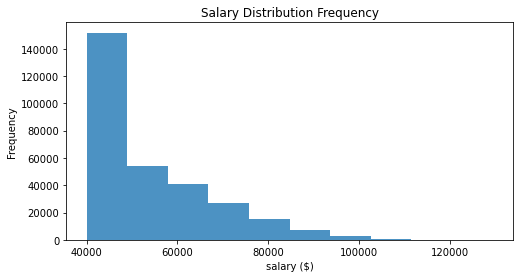

In [54]:
fig, axs = plt.pyplot.subplots(figsize=(8, 4))
ax = salaries['salary'].plot.hist(bins=10, alpha=.8)
plt.pyplot.title('Salary Distribution Frequency')
plt.pyplot.ylabel('Frequency')
plt.pyplot.xlabel('salary ($)')
plt.pyplot.show()
fig.savefig(f'{data_path}saldistro.png')

In [55]:
# Get the avg salary by title:
query9 = f'''
select title as "Job_Title", round(avg(salary::numeric), 2) as "Avg_Sal" from (
select emp_no, title from employee
left join title
on emp_title_id = title_id) a 
inner join salary b 
on a.emp_no = b.emp_no
group by (title)'''
avgSal_by_title = pd.read_sql_query(query9, cnx, index_col=['Job_Title'])
avgSal_by_title

,Avg_Sal
Job_Title,
Assistant Engineer,48564.43
Engineer,48535.34
Manager,51531.04
Senior Engineer,48506.80
Senior Staff,58550.17
Staff,58465.38
Technique Leader,48582.90


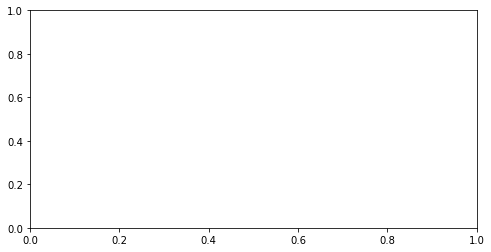

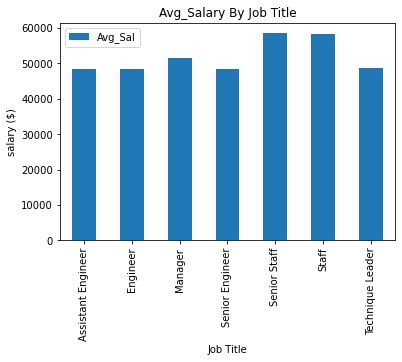

In [69]:
# Plotting the bar
fig, axs = plt.pyplot.subplots(figsize=(8, 4))
ax = avgSal_by_title.plot.bar()
plt.pyplot.title('Avg_Salary By Job Title')
plt.pyplot.xlabel('Job Title')
plt.pyplot.ylabel('salary ($)')
plt.pyplot.show()
fig.savefig(f'{data_path}avg_sal_distro.png')